# Homework 07: Ensemble Methods – Gradient Boosting

Over the past two weeks, we have expanded our machine learning toolkit by moving beyond linear regression to decision trees, which require careful selection of interacting hyperparameters. In Homework 6, you developed a systematic workflow for parameter tuning that balanced manual exploration with automated search methods (e.g., grid search) in order to optimize performance while gaining insight into model behavior.

This week, we take another step forward by studying **ensemble methods**, which combine multiple decision trees to produce stronger predictive models. Specifically, we will investigate **Gradient Boosting**, one of the most powerful and widely used non-deep learning methods in modern machine learning practice.

### What We Will Do in This Homework

To analyze and optimize our ensemble models, we will apply the two-phase strategy introduced in Homework 6. However, we will add **two new tools** to our tuning workflow:

* We will employ **randomized search instead of exhaustive grid search** to efficiently explore the hyperparameter space and identify promising regions without incurring the full combinatorial cost of evaluating every possible configuration.
* You will **store your best parameter values (and the resulting CV MAE) in a dictionary** to track improvements across experiments and maintain a clear record of how each parameter choice was made. This disciplined bookkeeping is essential for systematic model tuning.

Our two-phase strategy is thus (with new features in italics):

#### 1. First Phase

* Iteratively sweep through key parameters in **coarse ranges**, recording results in a dictionary
* Visualize training and cross-validation MAE
* Diagnose overfitting or underfitting
* Repeat the sweeps with progressively finer granularity
  (e.g., for `n_estimators`, you might begin with steps of 100, then refine to steps of 50, then 25, etc.)

#### 2. Second Phase

* Focus on the most promising or unstable parameter ranges identified in Phase 1
* Perform a randomized search within these narrower ranges using `RandomizedSearchCV`

We will follow this process for `GradientBoostingRegressor`, systematically tuning the most important parameters (see **Appendix 1** for a complete list):

`n_estimators`, `max_depth`, `max_features`, `min_samples_split`, `min_samples_leaf`

### Why We Are Not Tuning `learning_rate`

We will **not** tune `learning_rate` in this assignment.

In practice, `learning_rate` and `n_estimators` are tightly coupled: reducing the learning rate typically requires increasing the number of boosting stages. However, to isolate and reinforce the workflow of structured hyperparameter tuning, we will hold `learning_rate` fixed at its default value.

Gradient boosting models can appear to improve continuously as more estimators are added (particularly when the learning rate is small). However, this can lead to subtle overfitting. Overfitting can be controlled in several ways, including:

* Early stopping
* Monitoring the variance of cross-validation scores
* Comparing with a held-out test set (as a final check only)

In this homework, we will control overfitting in a simplified way by fixing the learning rate and tuning the remaining structural parameters. The goal is to strengthen your understanding of systematic model selection.

### Cross-Validation Strategy

We will continue using `RepeatedKFold` cross-validation to reduce variance in our CV MAE estimates.

However, computational cost increases quickly with the number of repeats. Use a staged approach:

* **Explore:** `n_repeats = 1`
* **Confirm:** `n_repeats = 3`
* **Finalize:** `n_repeats = 5` (only on your final 1–2 candidate models)

Be strategic about computational budget. Large sweeps with many repeats can significantly increase runtime.

### Before Starting

* Review the ensemble methods lesson materials, especially the Gradient Boosting video and notebook. The code in this homework builds directly on those resources.
* Refer to **Appendix 2** for tuning strategy guidance.
* Refer to **Appendix 3** for a comparison of randomized search and exhaustive grid search.

### Grading

This homework consists of 4 graded problems, each worth 13 points, and you get 3 points free if you complete the homework. 


In [1]:
# Useful imports

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import io
import zipfile
import time

from scipy.stats import uniform, randint

from sklearn.model_selection import train_test_split, cross_val_score, RepeatedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble        import GradientBoostingRegressor
from sklearn.metrics         import mean_absolute_error
from tqdm                    import tqdm

import matplotlib.ticker as mticker           # Optional: you can print out y axis labels as dollars. 

# globals

random_seed = 42

# utility code

# Optional:  Format y-axis labels as dollars with commas
def dollar_format(x, pos):
    return f'${x:,.0f}'

def format_hms(seconds):
    return time.strftime("%H:%M:%S", time.gmtime(seconds))

### Load the Ames Housing Dataset  

The code cell below will load the dataset for you.  This is the same dataset we used for the last two homeworks. 

> **Notice** that this code includes a useful optimization: **before downloading, it first
checks whether the files already exist.** This is an essential step when working with large datasets or when building deep learning models, where training can span hours or even days. By reusing previously downloaded files or saved models, you can avoid unnecessary work and significantly speed up your workflow.

For a detailed description of the dataset features, please refer to the **Appendix** in Homework 05. 

In [2]:
data_dir = "Ames_Dataset"                              # Directory where files will be stored

# Check if one of the files exists; if not, download and extract the zip file

if not os.path.exists( os.path.join(data_dir, "X_train.csv") ):
    print("Dataset files not found. Downloading...")
    zip_url = "https://www.cs.bu.edu/fac/snyder/cs505/Data/ames_housing.zip"
    try:
        response = requests.get(zip_url)
        response.raise_for_status()  # Raise an error for bad status codes
        # Extract the zip file into the designated directory
        with zipfile.ZipFile(io.BytesIO(response.content)) as zipf:
            zipf.extractall(data_dir)
        print("Files downloaded and extracted successfully.")
    except requests.exceptions.RequestException as e:
        print(f"Error downloading the file: {e}")
else:
    print("Dataset files already exist. Skipping download.")

# Load the datasets
X_train = pd.read_csv(os.path.join(data_dir, "X_train.csv"))
X_test  = pd.read_csv(os.path.join(data_dir, "X_test.csv"))
y_train = pd.read_csv(os.path.join(data_dir, "y_train.csv")).squeeze("columns")    
y_test  = pd.read_csv(os.path.join(data_dir, "y_test.csv")).squeeze("columns")

print("Training and testing datasets loaded successfully.")


Dataset files already exist. Skipping download.
Training and testing datasets loaded successfully.


## Prelude: Wrapper Functions for Running Ensemble Models

The following cells are adapted from the Week 7 video notebook on `GradientBoostingRegressor`, but have been refactored to be more generally useful (perhaps in your final project):

- **`run_model`** replaces the original `run_gradient_boosting_regressor` and accepts a parameter dictionary that can be applied to any model. You do not need to call this explicitly in this homework. 
- **`sweep_parameter`** is updated to work seamlessly with `run_model`, letting you:
  - Specify which model you want to use;  
  - Pass a dictionary of model parameters; and  
  - Return a modified parameter dictionary reflecting the best value of the parameter you swept, along with the corresponding MAE.

**Note:** Please do not change these cells unless you consult with the LFs first. Any alterations may cause downstream issues with the assignment.

In [3]:
# Run the model for testing and returning metrics.
# NOTE: You can NOT use this for running the model on the test set.

def run_model(model, 
              X_train, y_train, 
              n_repeats=5, 
              n_jobs=-1, 
              **model_params
             ):

    # Instantiate the model if a class is provided
    if isinstance(model, type):
        model = model(**model_params)
    else:                                    
        model.set_params(**model_params)    

    # Use negative MAE for cross-validation (since sklearn minimizes loss)
    neg_mae_scores = cross_val_score(
        model, 
        X_train, y_train,
        scoring='neg_mean_absolute_error',
        cv=RepeatedKFold(n_splits=5, n_repeats=n_repeats, random_state=random_seed), 
        n_jobs=n_jobs
    )
    
    mean_cv_mae = -np.mean(neg_mae_scores)
    std_cv_mae  =  np.std(neg_mae_scores)
    
    # Fit the model on the full training set
    model.fit(X_train, y_train)
    
    # Compute training MAE
    train_preds = model.predict(X_train)
    train_mae   = mean_absolute_error(y_train, train_preds)
    
    return mean_cv_mae, std_cv_mae, train_mae


In [4]:
def sweep_parameter(model,
                    Parameters,
                    param,
                    parameter_list,
                    X_train          = X_train,              # Defined above
                    y_train          = y_train,
                    verbose          = True,
                    show_mae         = True,
                    show_std         = False,
                    n_iter_no_change = None,
                    delta            = 0.001,
                    n_jobs           = -1,
                    n_repeats        = 5
                   ):
    

    start = time.time()
    Parameters = Parameters.copy()  # Avoid modifying the original dictionary
    
    cv_maes, std_cvs, train_maes = [], [], []
    no_improve_count = 0
    best_mae = float('inf')
    
    # Run over each value in parameter_list
    for p in tqdm(parameter_list, desc=f"Sweeping {param}"):
        Parameters[param] = p
        P_temp = Parameters.copy()
        P_temp.pop('MAE_found', None)  # Just in case
        
        cv_mae, std_cv, train_mae = run_model(
            model=model,
            X_train=X_train, y_train=y_train,
            n_repeats=n_repeats,
            n_jobs=n_jobs,
            **P_temp
        )
        cv_maes.append(cv_mae)
        std_cvs.append(std_cv)
        train_maes.append(train_mae)
        
        if cv_mae < best_mae - delta:
            best_mae = cv_mae
            no_improve_count = 0
        else:
            no_improve_count += 1
        
        if n_iter_no_change is not None and no_improve_count >= n_iter_no_change:
            print(f"Early stopping: No improvement after {n_iter_no_change} iterations.")
            break

    # Identify best parameter
    min_cv_mae = min(cv_maes)
    min_index = cv_maes.index(min_cv_mae)
    best_param = parameter_list[min_index]
    Parameters[param] = best_param
    Parameters['MAE_found'] = min_cv_mae

    # ---------- Plotting section ----------
    if verbose:
        partial_param_list = parameter_list[:len(cv_maes)]

        is_boolean = all(isinstance(val, bool) for val in partial_param_list)
        if is_boolean:
            x_vals = list(range(len(partial_param_list)))
            x_labels = [str(val) for val in partial_param_list]
        else:
            x_vals = partial_param_list
            x_labels = partial_param_list

        error_name = 'MAE'

        # Create appropriate number of subplots
        if show_std:
            fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8), sharex=True)
        else:
            fig, ax1 = plt.subplots(1, 1, figsize=(8, 4))

        ax1.set_title(f"{error_name} vs {param}")
        if show_mae:
            ax1.yaxis.set_major_formatter(mticker.FuncFormatter(dollar_format))

        ax1.plot(x_vals,
                 cv_maes,
                 marker='.', label="CV MAE", color='blue')
        ax1.plot(x_vals,
                 train_maes,
                 marker='.', label="Train MAE", color='green')
        ax1.scatter([x_vals[min_index]],
                    [min_cv_mae],
                    marker='x', label="Best CV MAE", color='red')

        ax1.set_ylabel(error_name)
        ax1.legend()
        ax1.grid()

        # Optional Std Dev Plot
        if show_std:
            ax2.set_title(f"CV Standard Deviation vs {param}")
            ax2.plot(x_vals, std_cvs, marker='.', label="CV MAE Std", color='blue')
            ax2.set_xlabel(param)
            ax2.set_ylabel("Standard Deviation")
            ax2.legend()
            ax2.grid(alpha=0.5)

            if is_boolean:
                ax2.set_xticks(x_vals)
                ax2.set_xticklabels(x_labels)
        else:
            ax1.set_xlabel(param)
            if is_boolean:
                ax1.set_xticks(x_vals)
                ax1.set_xticklabels(x_labels)

        plt.tight_layout()
        plt.show()

        end = time.time()
        print("Execution Time:", time.strftime("%H:%M:%S", time.gmtime(end - start)))

    return Parameters



## Problem 1: Iterative Parameter Sweeping and Visualization with `sweep_parameter(...)`

In this problem, you’ll tune five key hyperparameters of `GradientBoostingRegressor` by manually sweeping their values and visualizing the results using **Mean Absolute Error (MAE)** as your evaluation metric.

> **Important:** `GradientBoostingRegressor` runs on the CPU (not the GPU), even in Colab. Runtime depends heavily on:
>
> * Number of parameter values per sweep
> * Number of cross-validation repeats
> * `n_jobs` (parallel workers)

Be strategic about computational cost.

### Recommended Workflow

**Phase A — Exploration (Fast Mode)**

* Use `n_repeats = 1` or `2`
* Limit each parameter sweep to **≤ 20 values**
* Use coarse step sizes
* Goal: identify promising regions quickly

**Phase B — Refinement (Standard Mode)**

* Use `n_repeats = 3`
* Narrow ranges around best values
* Use smaller step sizes
* Limit sweeps to **≤ 15 values**

**Phase C — Final Confirmation (Full Mode)**

* Use `n_repeats = 5`
* Only evaluate the final narrow ranges
* Do not re-run large coarse sweeps at full repeats

> If a single sweep is taking more than ~5–10 minutes, reduce:
>
> * number of parameter values
> * `n_repeats`
> * or set `n_jobs=2` or `4` instead of `-1`



### Goal

Your objective is to apply a **coarse-to-fine tuning strategy**: begin with broad parameter ranges and coarse steps, then narrow the range and increase granularity as you approach a good model.

For example, when sweeping `n_estimators`, you might proceed as follows:

**Exploration:**

```python
range(200, 1201, 200)  # 6 values
```

**Refinement:**

```python
range(800, 1201, 50)   # 8 values
```

**Final confirmation:**

```python
range(900, 1001, 10)   # 11 values
```

Avoid sweeping hundreds of values — this will dramatically increase runtime.


### Step-by-Step Sweeping Procedure

#### Tip on Repeats

* Use **1–2 repeats** for early sweeps
* Increase to **3 repeats** for refinement
* Use **5 repeats only for final confirmation**

Do not run large coarse sweeps with 5 repeats.


#### 1. Sweep `n_estimators` (*integer values*)

* Start with a **coarse range** (e.g., 200–1200 step 200)
* Use `n_repeats = 1` or `2`
* Plot results and update `Parameters_GB`
* Narrow the range around the best region


#### 2. Sweep `max_depth` (*integer values*)

* Try small integers (e.g., 2–6 initially)
* Use step size of 1 or 2
* Avoid sweeping large depth ranges unnecessarily
* Update `Parameters_GB`



#### 3. Sweep `max_features` (*integer values*)

* Check `X_train.shape` for the feature count
* Use a reasonable subset (e.g., increments of 5 or 10)
* Avoid sweeping from 1 to full feature count unless justified



#### 4. Sweep `min_samples_split`

* Try small integer ranges (e.g., 2–15 step 3–5)
* Avoid large ranges



#### 5. Sweep `min_samples_leaf`

* Try small integers (e.g., 1–10 step 2–3)
* Refine only if needed



### Repeat with Finer Granularity

After the first pass:

* Narrow each parameter range around the best region
* Use smaller step sizes
* Reduce the number of candidate values
* Increase `n_repeats` gradually

You do **not** need to resweep every parameter each time.

Eventually aim for:

* `n_estimators`: step size of 10 (or 5 if runtime allows)
* Others: step size of 1 or 2

But only in narrow ranges.



### Ensure Robustness

Your final configuration must:

* Use **at least 5 repeats**
* Be based on narrow, well-justified ranges
* Reflect clear CV MAE improvement

This final configuration will form the foundation for Problem 2.



### Final Reporting

After completing 2–3 rounds of parameter sweeping:

* Report final tuned values stored in `Parameters_GB`
* Display final **CV MAE** clearly (in dollars)
* Respond to the graded question



In [5]:
Default_Parameters_GB = {
    'n_estimators'            : 100,             # The number of boosting stages to be run. More estimators can improve performance but increase training time.
    'max_depth'               : 3,               # Maximum depth of individual trees. Controls model complexity.
    'max_features'            : None,            # Number of features to consider when looking for best split. Can help reduce overfitting.
    'min_samples_split'       : 2,               # Defines the minimum number of samples required to split an internal node.
    'min_samples_leaf'        : 1,               # Specifies the minimum number of samples that must be present in a leaf node. 
    'random_state'            : random_seed,     # Controls randomness of boosting. Useful for reproducibility.
    'MAE_found'               : float('inf')     # NOT a model parameter, but will record the MAE found for the current parameter choices
}


In [6]:
# Make a copy of the default dictionary

Params_GB = Default_Parameters_GB.copy()


Sweeping n_estimators: 100%|██████████| 7/7 [01:14<00:00, 10.63s/it]


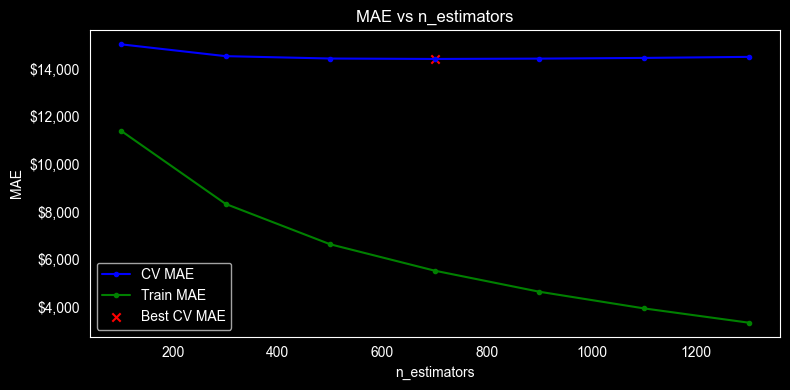

Execution Time: 00:01:14
After n_estimators sweep: {'n_estimators': 700, 'max_depth': 3, 'max_features': None, 'min_samples_split': 2, 'min_samples_leaf': 1, 'random_state': 42, 'MAE_found': np.float64(14416.402042294552)}


In [7]:
## ============================================================
## Phase A — Exploration (n_repeats=1, coarse ranges)
## ============================================================

Params_GB = Default_Parameters_GB.copy()

# 1. Sweep n_estimators (coarse)
Params_GB = sweep_parameter(
    model=GradientBoostingRegressor,
    Parameters=Params_GB,
    param='n_estimators',
    parameter_list=list(range(100, 1301, 200)),
    n_repeats=1
)
print("After n_estimators sweep:", Params_GB)

Sweeping max_depth: 100%|██████████| 6/6 [01:27<00:00, 14.52s/it]


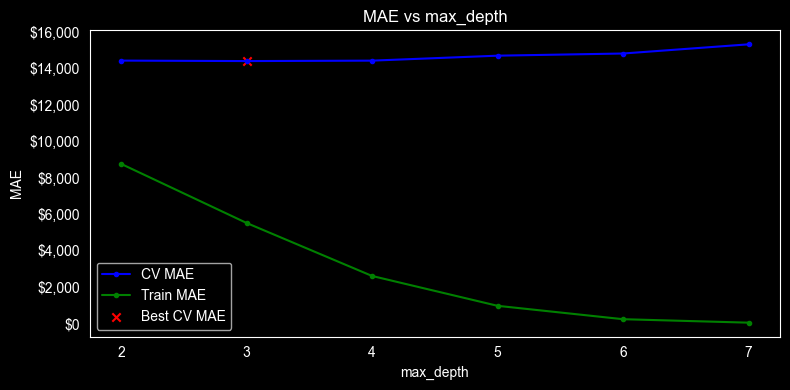

Execution Time: 00:01:27
After max_depth sweep: {'n_estimators': 700, 'max_depth': 3, 'max_features': None, 'min_samples_split': 2, 'min_samples_leaf': 1, 'random_state': 42, 'MAE_found': np.float64(14416.402042294552)}


In [8]:
# 2. Sweep max_depth (coarse)
Params_GB = sweep_parameter(
    model=GradientBoostingRegressor,
    Parameters=Params_GB,
    param='max_depth',
    parameter_list=list(range(2, 8)),
    n_repeats=1
)
print("After max_depth sweep:", Params_GB)

Sweeping max_features: 100%|██████████| 7/7 [00:34<00:00,  4.97s/it]


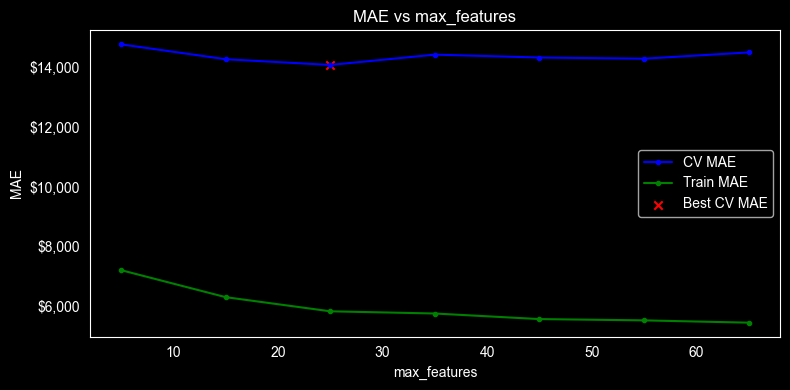

Execution Time: 00:00:34
After max_features sweep: {'n_estimators': 700, 'max_depth': 3, 'max_features': 25, 'min_samples_split': 2, 'min_samples_leaf': 1, 'random_state': 42, 'MAE_found': np.float64(14078.63536729226)}


In [9]:
# 3. Sweep max_features (coarse)
Params_GB = sweep_parameter(
    model=GradientBoostingRegressor,
    Parameters=Params_GB,
    param='max_features',
    parameter_list=list(range(5, 75, 10)),
    n_repeats=1
)
print("After max_features sweep:", Params_GB)

Sweeping min_samples_split: 100%|██████████| 5/5 [00:18<00:00,  3.73s/it]


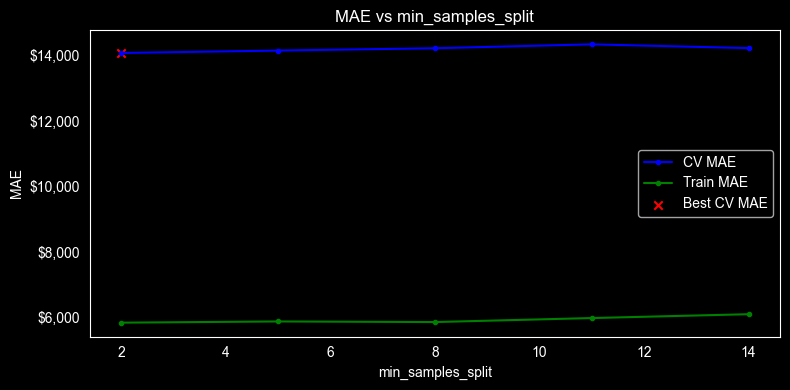

Execution Time: 00:00:18
After min_samples_split sweep: {'n_estimators': 700, 'max_depth': 3, 'max_features': 25, 'min_samples_split': 2, 'min_samples_leaf': 1, 'random_state': 42, 'MAE_found': np.float64(14078.63536729226)}


In [10]:
# 4. Sweep min_samples_split (coarse)
Params_GB = sweep_parameter(
    model=GradientBoostingRegressor,
    Parameters=Params_GB,
    param='min_samples_split',
    parameter_list=list(range(2, 16, 3)),
    n_repeats=1
)
print("After min_samples_split sweep:", Params_GB)

Sweeping min_samples_leaf: 100%|██████████| 6/6 [00:22<00:00,  3.75s/it]


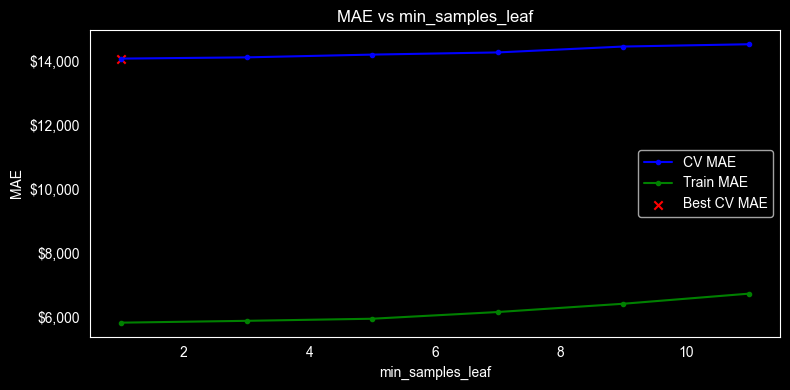

Execution Time: 00:00:22
After min_samples_leaf sweep: {'n_estimators': 700, 'max_depth': 3, 'max_features': 25, 'min_samples_split': 2, 'min_samples_leaf': 1, 'random_state': 42, 'MAE_found': np.float64(14078.63536729226)}


In [11]:
# 5. Sweep min_samples_leaf (coarse)
Params_GB = sweep_parameter(
    model=GradientBoostingRegressor,
    Parameters=Params_GB,
    param='min_samples_leaf',
    parameter_list=list(range(1, 12, 2)),
    n_repeats=1
)
print("After min_samples_leaf sweep:", Params_GB)

Sweeping n_estimators: 100%|██████████| 9/9 [00:51<00:00,  5.70s/it]


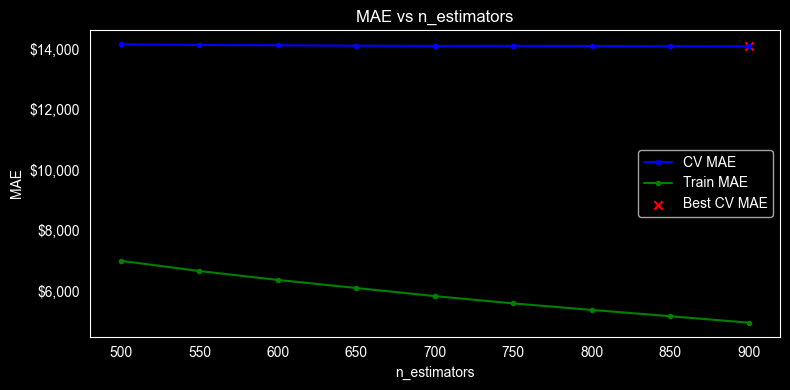

Execution Time: 00:00:51
After n_estimators refinement: {'n_estimators': 900, 'max_depth': 3, 'max_features': 25, 'min_samples_split': 2, 'min_samples_leaf': 1, 'random_state': 42, 'MAE_found': np.float64(14091.399899056305)}


In [12]:
## ============================================================
## Phase B — Refinement (n_repeats=3, narrower ranges)
## ============================================================

# 1. Refine n_estimators: Phase A best = 700, narrow to 500-900
Params_GB = sweep_parameter(
    model=GradientBoostingRegressor,
    Parameters=Params_GB,
    param='n_estimators',
    parameter_list=list(range(500, 901, 50)),
    n_repeats=3
)
print("After n_estimators refinement:", Params_GB)

Sweeping max_depth: 100%|██████████| 4/4 [00:33<00:00,  8.44s/it]


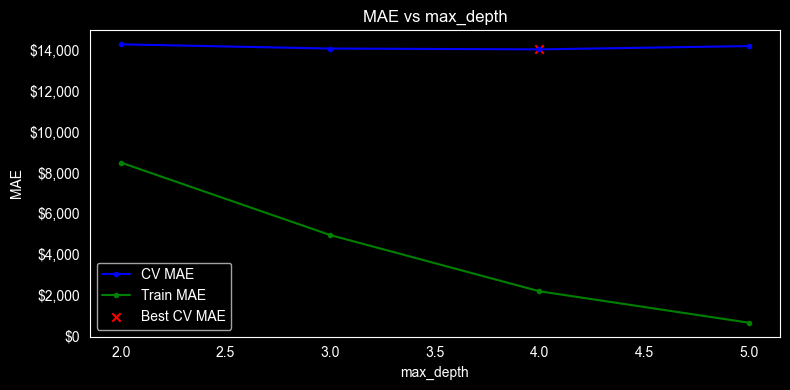

Execution Time: 00:00:33
After max_depth refinement: {'n_estimators': 900, 'max_depth': 4, 'max_features': 25, 'min_samples_split': 2, 'min_samples_leaf': 1, 'random_state': 42, 'MAE_found': np.float64(14051.404655932483)}


In [13]:
# 2. Refine max_depth: Phase A best = 3, narrow to 2-5
Params_GB = sweep_parameter(
    model=GradientBoostingRegressor,
    Parameters=Params_GB,
    param='max_depth',
    parameter_list=list(range(2, 6)),
    n_repeats=3
)
print("After max_depth refinement:", Params_GB)

Sweeping max_features: 100%|██████████| 7/7 [01:04<00:00,  9.24s/it]


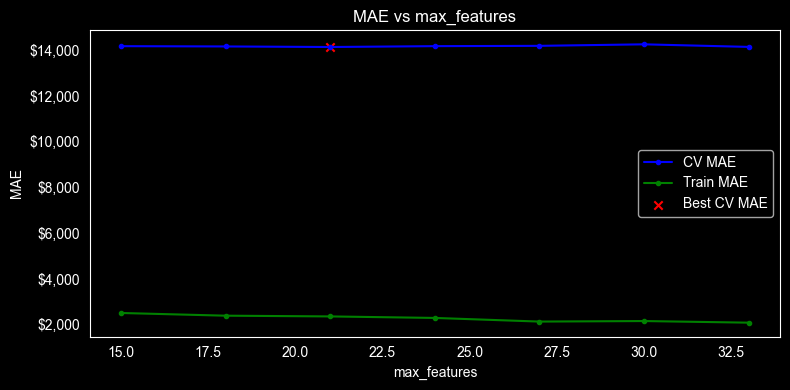

Execution Time: 00:01:04
After max_features refinement: {'n_estimators': 900, 'max_depth': 4, 'max_features': 21, 'min_samples_split': 2, 'min_samples_leaf': 1, 'random_state': 42, 'MAE_found': np.float64(14140.73712206137)}


In [14]:
# 3. Refine max_features: Phase A best = 25, narrow to 15-35
Params_GB = sweep_parameter(
    model=GradientBoostingRegressor,
    Parameters=Params_GB,
    param='max_features',
    parameter_list=list(range(15, 36, 3)),
    n_repeats=3
)
print("After max_features refinement:", Params_GB)

Sweeping min_samples_split: 100%|██████████| 7/7 [00:56<00:00,  8.14s/it]


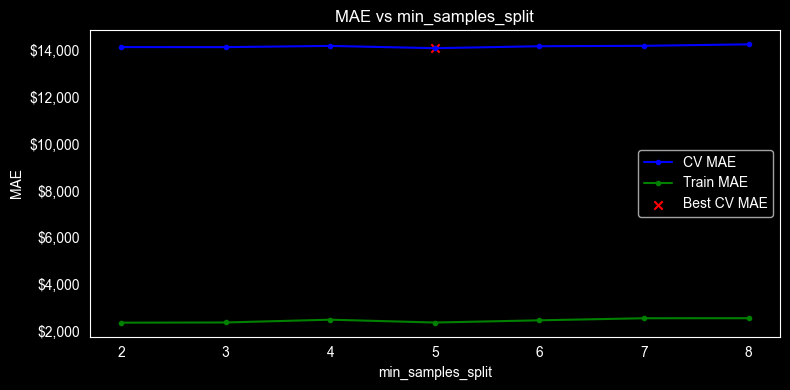

Execution Time: 00:00:57
After min_samples_split refinement: {'n_estimators': 900, 'max_depth': 4, 'max_features': 21, 'min_samples_split': 5, 'min_samples_leaf': 1, 'random_state': 42, 'MAE_found': np.float64(14093.414083171014)}


In [15]:
# 4. Refine min_samples_split: Phase A best = 2, narrow to 2-8
Params_GB = sweep_parameter(
    model=GradientBoostingRegressor,
    Parameters=Params_GB,
    param='min_samples_split',
    parameter_list=list(range(2, 9)),
    n_repeats=3
)
print("After min_samples_split refinement:", Params_GB)

Sweeping n_estimators: 100%|██████████| 9/9 [01:16<00:00,  8.53s/it]


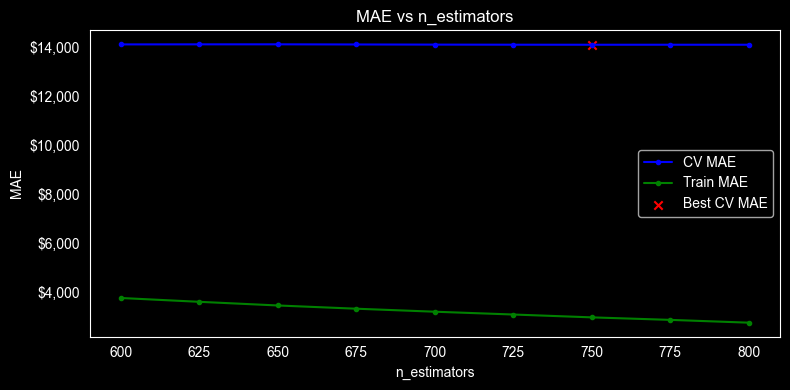

Execution Time: 00:01:16


Sweeping max_features: 100%|██████████| 11/11 [01:59<00:00, 10.84s/it]


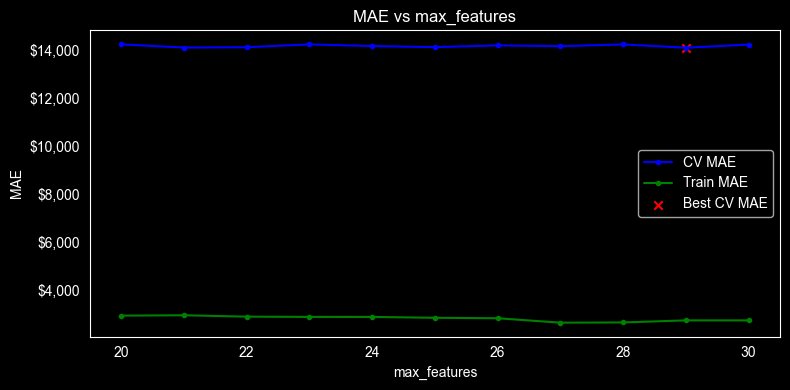

Execution Time: 00:01:59

Final Parameters: {'n_estimators': 750, 'max_depth': 4, 'max_features': 29, 'min_samples_split': 5, 'min_samples_leaf': 1, 'random_state': 42, 'MAE_found': np.float64(14090.923311335235)}

Final CV MAE: $14,090.92


In [16]:
## ============================================================
## Phase C — Final Confirmation (n_repeats=5)
## ============================================================
## After running Phase B, update the ranges below to center
## on the best values found. These are the most impactful params.

# Final narrow sweep on n_estimators (adjust range after Phase B)
Params_GB = sweep_parameter(
    model=GradientBoostingRegressor,
    Parameters=Params_GB,
    param='n_estimators',
    parameter_list=list(range(600, 801, 25)),
    n_repeats=5
)

# Final narrow sweep on max_features (adjust range after Phase B)
Params_GB = sweep_parameter(
    model=GradientBoostingRegressor,
    Parameters=Params_GB,
    param='max_features',
    parameter_list=list(range(20, 31)),
    n_repeats=5
)

print("\nFinal Parameters:", Params_GB)
print(f"\nFinal CV MAE: ${Params_GB['MAE_found']:,.2f}")

### Summary

Phase A we sweep all 5 hyperparameters (`n_estimators`, `max_depth`, `max_features`, `min_samples_split`, `min_samples_leaf`) with coarse (wide) ranges and `n_repeats=1` to quickly identify promising regions.

Phase B we refine 4 of them (`n_estimators`, `max_depth`, `max_features`, `min_samples_split`) with narrower ranges and `n_repeats=3`. We drop `min_samples_leaf` because in Phase A we find the default value of 1 is optimal.

Phase C we narrow down to `n_estimators` and `max_features` because:
1. `max_depth` settled at 4 in Phase B with a step of 1.
2. `min_samples_split` settled at 5 in Phase B with a step of 1.
3. `n_estimators` and `max_features` were the two parameters that still showed sensitivity with a wide range and step size. This means small changes in their values actually moved the CV MAE. They benefited from the extra precision of a final narrow sweep with 5 repeats.

### Problem 1 Graded Answer

Set `a1` to the CV MAE score of your best model. 

In [17]:
 # Your answer here

a1 = Params_GB['MAE_found']

In [18]:
# DO NOT change this cell in any way

print(f'a1 = ${a1:,.2f}')

a1 = $14,090.92


## Problem 2: Use `RandomizedSearchCV` to Explore Alternatives

In this problem, you will use **randomized search** to explore the hyperparameter space more broadly than in Problem 1.

Rather than sweeping one parameter at a time, `RandomizedSearchCV` samples random combinations of parameters from specified distributions. This allows you to explore interactions between parameters more efficiently than manual sweeps.

Use the final parameter ranges you identified in Problem 1 — or slightly narrower ranges centered around your best values.


### Setup Requirements

* Define parameter distributions using `randint(lb, ub)` for **all** five parameters.

  * Remember that `randint(a, b)` samples integers from `a` to `b - 1`.
  * This gives you a granularity of 1 automatically.
* Use `RepeatedKFold` for cross-validation so that your scoring is consistent with Problem 1.
* Use `scoring='neg_mean_absolute_error'`.


### Runtime Strategy (Very Important)

Randomized search can become expensive quickly. Be strategic.

Start conservatively:

```python
n_iter = 30
n_repeats = 2
```

If runtime is comfortable (e.g., under ~15–20 minutes total), you may increase gradually:

* Try `n_iter = 60`
* Or increase to `n_repeats = 3`

Only increase these values if your notebook is running smoothly and not approaching time or memory limits.

> ⚠️ Do not immediately set `n_iter=100` with 5 repeats. That can result in thousands of model fits and long runtimes.

Your goal is not to exhaust the search space — it is to intelligently explore it.



### What to Report

After fitting `RandomizedSearchCV`:

* Print the best parameter combination (`best_params_`)
* Report the corresponding **CV MAE**
* Set `a2` equal to the best CV MAE found



### Interpretation

It is entirely possible that randomized search does **not** outperform your manually tuned model from Problem 1.
Randomized search is most valuable when:

* The search space is large
* Parameter interactions matter
* Manual sweeping becomes inefficient

Its purpose here is to broaden exploration and compare strategies — not to guarantee improvement.



In [19]:
## Problem 2: RandomizedSearchCV

# Define parameter distributions centered on Problem 1 results
param_dist = {
    'n_estimators'      : randint(600, 1001),       # integers from 600 to 1000
    'max_depth'         : randint(3, 6),             # integers from 3 to 5
    'max_features'      : randint(20, 35),           # integers from 20 to 34
    'min_samples_split' : randint(2, 10),            # integers from 2 to 9
    'min_samples_leaf'  : randint(1, 6),             # integers from 1 to 5
}

model = GradientBoostingRegressor(random_state=random_seed)

rand_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_dist,
    n_iter=50,
    cv=RepeatedKFold(n_splits=5, n_repeats=3, random_state=random_seed),
    scoring='neg_mean_absolute_error',
    random_state=random_seed,
    n_jobs=-1,
    verbose=1
)

start = time.time()
rand_search.fit(X_train, y_train)
end = time.time()

print(f"\nExecution Time: {format_hms(end - start)}")
print(f"\nBest parameters: {rand_search.best_params_}")
print(f"Best CV MAE: ${-rand_search.best_score_:,.2f}")

Fitting 15 folds for each of 50 candidates, totalling 750 fits

Execution Time: 00:04:00

Best parameters: {'max_depth': 3, 'max_features': 20, 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 725}
Best CV MAE: $14,025.61


### Problem 2 Graded Answer

Set `a2` to the best CV MAE score found using randomized search.

In [20]:
 # Your answer here

a2 = -rand_search.best_score_

In [21]:
# DO NOT change this cell in any way

print(f'a2 = ${a2:,.2f}')

a2 = $14,025.61


## Problem 3: Evaluate and Select Your Final Model

At this point, you may have **two candidate models**:

1. The model obtained from **Problem 1** (manual parameter sweeps)
2. The model obtained from **Problem 2** (`RandomizedSearchCV`)

Your task is to select **one final model** and evaluate it on the **held-out test set**.


### Step 1: Choose the Best Model (Using CV Only)

Base your decision primarily on:

* **Mean CV MAE**
* Stability of CV results
* Gap between training MAE and CV MAE (sign of overfitting)

Guidelines:

* Prefer the model with the **lower CV MAE**
* If CV MAE values are very close, prefer the model with:

  * Smaller training–CV gap
  * More stable behavior across parameter ranges
* If the two models are indistinguishable within reasonable CV variability, either choice is acceptable.

> Do **not** use the test set to decide between models.


### Step 2: Train the Final Model and Evaluate on the Test Set

Once you have selected your final configuration:

* Instantiate a new `GradientBoostingRegressor` with the chosen parameters
* Fit it on the **full training set**
* Generate predictions on the **test set**
* Compute the **test MAE**

This test MAE is your final out-of-sample performance estimate.

> **Important:** You may not use `run_model` here. That function is designed for cross-validation during tuning.
> As in Homework 06, you must explicitly fit the final model and evaluate it on `X_test` and `y_test`.


### What to Report

* `a3a`: Which model you selected

  * `1` = Problem 1 model
  * `2` = Problem 2 model
  * `3` = Essentially the same model
* `a3b`: The final **test MAE** (in dollars)


### Conceptual Reminder

Cross-validation is used for **model selection**.
The test set is used **once**, at the end, to estimate generalization performance.



In [22]:
# Problem 3: Evaluate and Select Final Model

# Compare the two models
print("Problem 1 (manual sweep) CV MAE:", f"${a1:,.2f}")
print("Problem 2 (randomized search) CV MAE:", f"${a2:,.2f}")
print()

# Problem 2 model had lower CV MAE, so select it
best_params = rand_search.best_params_
print("Selected model: Problem 2 (RandomizedSearchCV)")
print("Parameters:", best_params)

# Train final model on full training set and evaluate on test set
final_model = GradientBoostingRegressor(
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    max_features=best_params['max_features'],
    min_samples_split=best_params['min_samples_split'],
    min_samples_leaf=best_params['min_samples_leaf'],
    random_state=random_seed
)

final_model.fit(X_train, y_train)
y_pred = final_model.predict(X_test)
test_mae = mean_absolute_error(y_test, y_pred)

print(f"\nTest MAE: ${test_mae:,.2f}")

Problem 1 (manual sweep) CV MAE: $14,090.92
Problem 2 (randomized search) CV MAE: $14,025.61

Selected model: Problem 2 (RandomizedSearchCV)
Parameters: {'max_depth': 3, 'max_features': 20, 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 725}

Test MAE: $14,178.53


### Problem 3 Graded Answers

Set `a3a` to the number of the best model found:
- 1 = Problem 1 model
- 2 = Problem 2 model
- 3 = Essentially the same model

In [23]:
 # Your answer here

a3a = 2                     # Problem 2 model had lower CV MAE

In [24]:
# DO NOT change this cell in any way

print(f'a3a = {a3a}')

a3a = 2


Set `a3b` to the test MAE of your best model. 

In [25]:
 # Your answer here

a3b = test_mae

In [26]:
# DO NOT change this cell in any way

print(f'a3b = ${a3b:,.2f}')

a3b = $14,178.53


## Appendix 1: Which `GradientBoostingRegressor` parameters are most important?

We will focus on the top **four** parameters in this list for `GradientBoostingRegressor`. 

---

**Most Important Parameters**

1. **learning_rate** (default: **0.1**)  
   *Controls the contribution of each individual tree. A lower learning rate generally requires more trees but can lead to improved generalization.*

2. **n_estimators** (default: **100**)  
   *Specifies the number of boosting stages (i.e., the number of trees in the ensemble). More estimators can improve performance but also increase the risk of overfitting if not tuned properly.*

3. **max_depth** (default: **3**)  
   *Limits the depth of the individual regression trees. Restricting the depth helps control overfitting and reduces the complexity of each base learner.*

4. **max_features** (default: **None**)  
   *Controls the number of features to consider when looking for the best split. Adjusting this can influence the bias-variance trade-off of the model.*

5. **min_samples_split** (default: **2**)  
   *Defines the minimum number of samples required to split an internal node. This parameter controls the growth of each tree and can prevent overly specific splits.*

6. **min_samples_leaf** (default: **1**)  
   *Specifies the minimum number of samples that must be present in a leaf node. This helps in ensuring that trees do not become too tailored to the training data.*

---

**Less Important Parameters**

7. **max_leaf_nodes** (default: **None**)  
    *An optional parameter that sets a maximum number of leaf nodes for each tree. This can provide an additional way to control the complexity of the model.*

8. **subsample** (default: **1.0**)  
   *Determines the fraction of samples used for fitting each individual tree. Values less than 1.0 introduce randomness into the boosting process, which can help reduce overfitting.*

9. **loss** (default: **'squared_error'**)  
   *Determines the loss function to be optimized during training. Different loss functions can be used depending on the specific characteristics of the regression problem.*





## Appendix 2: Tuning and Selecting Complex Models

This appendix offers practical guidance for tuning complex models like Gradient Boosting and for interpreting validation results to choose the best-performing configuration. It combines strategy, visualization, and decision-making heuristics into one workflow.



### 1. Using `sweep_parameter` for Single-Parameter Exploration

The function `sweep_parameter` automates parameter tuning by iterating over a range of values (e.g., `n_estimators`) and tracking performance across:

* **Training MAE**: Fit to training data
* **Cross-Validation (CV) MAE**: Generalization estimate across folds (and repeats)

**How to Interpret the Plots:**

* **Training vs. CV MAE**: A growing gap often signals overfitting; high values for both may indicate underfitting.
* **CV MAE Curve**: Choose values near the minimum (valley), ideally where the curve flattens.
* **Watch Plot Scales**: A flat-looking curve may conceal meaningful differences if the y-axis scale is tight. Always consider actual values, not just shapes.



### 2. Tuning Strategy: Coarse-to-Fine

* Start with **broad ranges and coarse steps** (e.g., 100–1000 by 100).
* Once you find a promising region, **narrow the range and reduce step size** (e.g., 500–1000 by 25 or 10).


### 3. Using Repeated Cross-Validation Effectively

**Why Repeat?**
Repeated CV provides more stable estimates by averaging results across multiple random folds, reducing variance due to data splits.

**How Many Repeats?**

* **Early (Broad Sweeps):** 1–2 repeats for speed
* **Fine Tuning:** 5–10 repeats for stability and confidence in final selection

**Trade-Offs:**

* More repeats increase reliability, but also computation time. Scale up only after narrowing your search.


### 4. Model Selection: Key Indicators

When comparing models or parameter settings:

* **Minimize Mean CV MAE**: This is your primary signal of generalization performance during model tuning.

* **Look for Stability**: Favor flatter regions (plateaus) near the minimum of the CV MAE curve, rather than sharp dips that may reflect overfitting or noise.

* **Avoid Overfitting**: If you examine the test MAE **after tuning,** be cautious of a *growing gap* between CV MAE and test MAE.

  * This can suggest the model is fitting cross-validation folds too tightly.
  * However, do **not** use test MAE to guide parameter choices — reserve it as a **final check** only.

* **[Optional] Prioritize Consistency**: A lower standard deviation of CV scores indicates more stable performance across different splits.

* **Interpret Plots Carefully**: Always consider the **scale** of the y-axis when comparing curves. Flat-looking trends might conceal meaningful differences if the axis range is small.


### 5. Workflow Tips for Efficient Tuning

* **Visualize Everything**: Always plot training/CV/test MAE of CV scores for insight.
* **Track Experiments**: Use a dictionary (or a list of dictionaries) to record parameter settings and results.
* **Scale Up Thoughtfully**: Start simple and add complexity (more repeats, finer search) only when needed.
* **Use `GridSearchCV` and `RandomizedSearchCV` Judiciously**:

  * Start with random search to identify promising regions, then use grid search for final tuning.
  * Be aware that both methods may take significant time—especially without a progress bar.
* **Enable Parallelism with `n_jobs=-1`**: This will use all available CPU cores.

  * If you see warnings (e.g., “a worker stopped”), you may be running out of memory. Reduce `n_jobs` (e.g., to 4) if needed.



By combining thoughtful parameter sweeps, smart use of repeated CV, and careful reading of validation curves and variance, you’ll build models that not only perform well but generalize reliably.


## Appendix 3: Randomized Search vs. Grid Search for Gradient Boosting

This appendix compares two strategies for hyperparameter tuning—**randomized search** and **grid search**—using `GradientBoostingRegressor` as the working example. 

### 1. Problem Setup

Suppose you are training a `GradientBoostingRegressor` and want to optimize its predictive performance by tuning the key hyperparameters above.

```python
from sklearn.ensemble import GradientBoostingRegressor

model = GradientBoostingRegressor(random_state=random_seed)
```



### 2. Grid Search

**Grid search** evaluates **all** combinations of parameter values in a predefined grid.

#### Define Parameter Grid

```python
param_grid = {

    'n_estimators'      : range(1000,1501,100),
    'max_depth'         : range(5,51,5),
    'max_features'      : [3, 4, 5],
    'min_samples_split' : [2,4,6,8],             
    'min_samples_leaf'  : [1,2,3],   
}
```

#### Run `GridSearchCV`

```python
from sklearn.model_selection import GridSearchCV

grid = GridSearchCV(
    estimator=GradientBoostingRegressor(),
    param_grid=param_grid,
    cv=RepeatedKFold(n_splits=5, n_repeats=5, random_state=42), 
    scoring='neg_mean_absolute_error',
    n_jobs=-1
)
grid.fit(X_train, y_train)
print("Best parameters:", grid.best_params_)
```

* **Pros**: Exhaustive—guarantees best settings *within* your grid
* **Cons**: Combinatorial explosion—3×3×3×2 = 54 fits! Time and resources grow rapidly



### 3. Randomized Search

**Randomized search** samples a fixed number of combinations from **distributions** over the parameter space.

#### Define Distributions

This is a significant difference with grid search: you must specify a random-number generator instead of
giving a list of explicit values. 

```python
from scipy.stats import uniform, randint

param_dist = {
    'n_estimators'      : randint(100, 500),        # integers from 100 to 499
    'max_depth'         : randint(3, 8),            # integers from 3 to 7
    'max_features'      : randint(2, 15),            
    'min_samples_split' : randint(2, 10),             
    'min_samples_leaf'  : randint(1, 8),             
}
```

#### Run `RandomizedSearchCV`

```python
from sklearn.model_selection import RandomizedSearchCV

rand = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_dist,
    n_iter=20,                 # try 20 random combinations
    cv=RepeatedKFold(n_splits=5, n_repeats=5, random_state=random_seed), 
    scoring='neg_mean_absolute_error',
    random_state=random_seed,
    n_jobs=-1
)
rand.fit(X_train, y_train)
print("Best parameters:", rand.best_params_)
```

* **Pros**: Efficient—fixed number of combinations regardless of parameter count
* **Cons**: May miss the absolute best—but often finds near-optimal solutions much faster



### 4. When to Use Which?

| Scenario          | Use Grid Search                 | Use Randomized Search               |
| ----------------- | ------------------------------- | ----------------------------------- |
| Search space size | Small, well-defined             | Large or continuous                 |
| Compute budget    | High                            | Moderate or limited                 |
| Goal              | Exhaustive search within a grid | Fast discovery of promising regions |
| Parameter types   | Discrete                        | Continuous or mixed                 |
| Tuning stage      | Final fine-tuning               | Early-stage exploration             |



### 5. Best Practices

1. **Start with Randomized Search**

   * Identify promising parameter ranges quickly and cheaply.

2. **Refine with Grid Search**

   * Use a tighter grid centered around the best values from the randomized search.

3. **Use Log Scale for Learning Rates**

   * For scale-sensitive values like `learning_rate`, sample from log-distributions (e.g., `loguniform(1e-3, 1e0)`).

4. **Validate on a Held-Out Test Set**

   * After tuning, always check your model’s performance on a separate test set to assess generalization.


